In [ ]:
from looptrace import image_io
from looptrace import image_processing_functions as ip
from looptrace.gaussfit import fitSymmetricGaussian3D
#import open3d as o3d
import numpy as np
from scipy.spatial.transform import Rotation
import tqdm
import pandas as pd
from scipy import ndimage as ndi
from matplotlib import pyplot as plt


#input_folder = r'M:\Kai\Image_processing\2023-05-31_Tetraspeck_precision_tests\quad_filter_561_640_trigger_300nmZ'
#imgs, positions = image_io.stack_nd2_to_dask(input_folder)

input_folder = '/path/to/experiment/images/sequential_images_folder'
imgs, positions = image_io.multi_ome_zarr_to_dask(input_folder)
drift_table = pd.read_csv('path/to/experiment/analysis/exp_drift_correction.csv', index_col=0)

In [ ]:
full_pos = 20
ref_frame = 20
ref_ch = 0
T = imgs[full_pos].shape[0]
C = imgs[full_pos].shape[1]
ref_rois = ip.generate_bead_rois(imgs[full_pos][ref_frame,ref_ch].compute(), 2000, 5000, n_points = -1)
#ref = o3d.geometry.PointCloud()
#ref.points = o3d.utility.Vector3dVector(ref_rois)
rois = ref_rois[np.random.choice(ref_rois.shape[0], 50, replace=False)]
bead_roi_px = 8
bead_imgs = np.zeros((len(rois),T,C,bead_roi_px,bead_roi_px,bead_roi_px))
bead_imgs_dc = np.zeros((len(rois),T,C,bead_roi_px,bead_roi_px,bead_roi_px))

fits = []
ref_img = imgs[full_pos][ref_frame, ref_ch].compute()
for t in tqdm.tqdm(range(T)):
    pos = drift_table.position.unique()[full_pos]
    course_shift = drift_table[(drift_table.position == pos) & (drift_table.frame == t)][['z_px_course', 'y_px_course', 'x_px_course']].values[0]
    fine_shift = drift_table[(drift_table.position == pos) & (drift_table.frame == t)][['z_px_fine', 'y_px_fine', 'x_px_fine']].values[0]
    for c in [ref_ch]:#range(C):
        img = imgs[full_pos][t, c].compute()
        for i, roi in enumerate(rois):
            bead_img=ip.extract_single_bead(roi, img, bead_roi_px=bead_roi_px, drift_course=course_shift)
            fit = fitSymmetricGaussian3D(bead_img, sigma=1, center='max')[0]
            #fit_global = fit[2:5] + course_shift + roi[]
            fits.append([full_pos, t, c, i] + list(fit))
            bead_imgs[i,t,c] = bead_img.copy()
            bead_imgs_dc[i,t,c] = ndi.shift(bead_img, shift=fine_shift)


fits_tmp = pd.DataFrame(fits, columns=['full_pos','t', 'c', 'roi', 'BG', 'A', 'z_loc', 'y_loc', 'x_loc', 'sigma_z', 'sigma_xy'])
#fits2[['z', 'y', 'x']] = fits2[['z', 'y', 'x']] + rois2[::2]


In [6]:
import napari
n = napari.view_image(bead_imgs)
n.add_image(bead_imgs_dc)

<Image layer 'bead_imgs_dc' at 0x2c58eea0a60>

In [125]:
fits = fits_tmp.copy()

fits.loc[:, ['y_loc', 'x_loc', 'sigma_xy']] = fits.loc[:,  ['y_loc', 'x_loc', 'sigma_xy']]*110 #Scale xy coordinates to nm (use xy pixel size from exp)
fits.loc[:, ['z_loc', 'sigma_z']] = fits.loc[:, ['z_loc', 'sigma_z']]*300 #Scale z coordinates to nm (use slice spacing from exp)

ref_frame = 20
from scipy.stats import trim_mean
ref_points = fits.loc[(fits.t == ref_frame) & (fits.c == 0), ['z_loc', 'y_loc', 'x_loc']].to_numpy() #Fits of fiducial beads in ref frame
res = []
for t in tqdm.tqdm(range(T)):
    mov_points = fits.loc[(fits.t == t) & (fits.c == 0), ['z_loc', 'y_loc', 'x_loc']].to_numpy() #Fits of fiducial beads in moving frame
    #shift = trim_mean(mov_points-ref_points, 0.2, axis=0)
    shift = drift_table.loc[(drift_table.position == pos) & (drift_table.frame == t), ['z_px_fine', 'y_px_fine', 'x_px_fine']].values[0]
    shift[0] =  shift[0] * 300 #Extract calculated drift correction from drift correction file.
    shift[1] =  shift[1] * 110
    shift[2] =  shift[2] * 110
    fits.loc[(fits.t == t), ['z_dc', 'y_dc', 'x_dc']] = mov_points + shift #Apply precalculated drift correction to moving fits
    fits.loc[(fits.t == t), ['z_dc_rel', 'y_dc_rel', 'x_dc_rel']] =  np.abs(fits.loc[(fits.t == t), ['z_dc', 'y_dc', 'x_dc']].to_numpy() - ref_points)#Find offset between moving and reference points.
    fits.loc[(fits.t == t), ['euc_dc_rel']] = np.sqrt(np.sum((fits.loc[(fits.t == t), ['z_dc', 'y_dc', 'x_dc']].to_numpy() - ref_points)**2, axis=1)) #Calculate 3D eucledian distance between points and reference
    res.append(shift)
print(res)
fits['A_to_BG'] = fits['A']/fits['BG']
fits['QC'] = 0
fits.loc[fits['A_to_BG'] > 2, 'QC'] = 1
#res.transformation[:3,3]

  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:00<00:00, 113.76it/s]

[array([  7.38462606, -24.47150889,  -9.85896125]), array([ 6.36418915, 92.07135281, 93.39973831]), array([-36.40586448,   2.3389521 ,  92.95873945]), array([-66.76704506,  58.71962663,  10.8685303 ]), array([-34.26090795,  30.92526227, -83.96681505]), array([ 24.32042805,  19.19176944, -84.88461108]), array([-28.03697516,  30.38750366,   2.57334656]), array([-17.60015728, -15.83820526, -11.65145956]), array([-68.88574024, -60.77809443,  22.07665835]), array([ 10.55882448, -56.74377468, -22.08352993]), array([-10.63119178, -34.11115778,  53.88228189]), array([   8.19058102,   -6.36042858, -104.6023644 ]), array([-30.49022208, -51.16639028, -55.86690678]), array([-78.71169337, -83.53517314,  65.19282612]), array([-41.03098749,  -9.32240076, 104.90379018]), array([-33.00226906,  84.62319276, -27.77509762]), array([-55.39031386, -87.51357783, -39.17885034]), array([-54.8830105 ,  88.40604923, 109.00568425]), array([ -28.12761014, -103.98933039,  -75.84166365]), array([-40.62439928, 106.23

7.995077048340704 3.953430747322159 3.4280593416680745 12.524894469184655
0.25     3.370191
0.75    14.171272
Name: z_dc_rel, dtype: float64 0.25    1.704394
0.75    8.084603
Name: y_dc_rel, dtype: float64 0.25    1.394974
0.75    6.700576
Name: x_dc_rel, dtype: float64 0.25     7.358917
0.75    19.722896
Name: euc_dc_rel, dtype: float64
11.725412269170334 7.699821003244607 6.75416104023506 17.708290865577943
54.673940368943484 41.679072076794256 51.3672515371817 85.40347691605659


(0.0, 100.0)

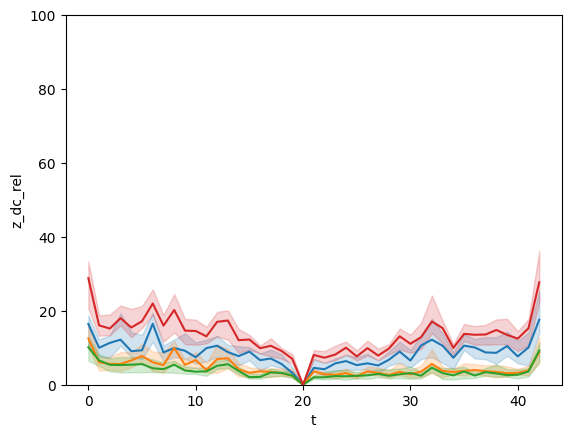

In [128]:
import seaborn as sns
sns.lineplot(data = fits[(fits.QC==1) & (fits.c ==0)], y = 'z_dc_rel', x='t',  estimator=np.median)
sns.lineplot(data = fits[(fits.QC==1) & (fits.c ==0)], y = 'y_dc_rel', x='t',  estimator=np.median)
sns.lineplot(data = fits[(fits.QC==1) & (fits.c ==0)], y = 'x_dc_rel', x='t',  estimator=np.median)
sns.lineplot(data = fits[(fits.QC==1) & (fits.c ==0)], y = 'euc_dc_rel', x='t',  estimator=np.median)
print(fits[(fits.QC==1) & (fits.c ==0)].z_dc_rel.median(), fits[(fits.QC==1) & (fits.c ==0)].y_dc_rel.median(), fits[(fits.QC==1) & (fits.c ==0)].x_dc_rel.median(), fits[(fits.QC==1) & (fits.c ==0)].euc_dc_rel.median())
print(fits[(fits.QC==1) & (fits.c ==0)].z_dc_rel.quantile([0.25,0.75]), fits[(fits.QC==1) & (fits.c ==0)].y_dc_rel.quantile([0.25,0.75]), fits[(fits.QC==1) & (fits.c ==0)].x_dc_rel.quantile([0.25,0.75]), fits[(fits.QC==1) & (fits.c ==0)].euc_dc_rel.quantile([0.25,0.75]))
print(fits[(fits.QC==1) & (fits.c ==0)].z_dc_rel.mean(), fits[(fits.QC==1) & (fits.c ==0)].y_dc_rel.mean(), fits[(fits.QC==1) & (fits.c ==0)].x_dc_rel.mean(), fits[(fits.QC==1) & (fits.c ==0)].euc_dc_rel.mean())
print(fits[(fits.QC==1) & (fits.c ==0)].z_dc_rel.std(), fits[(fits.QC==1) & (fits.c ==0)].y_dc_rel.std(), fits[(fits.QC==1) & (fits.c ==0)].x_dc_rel.std(), fits[(fits.QC==1) & (fits.c ==0)].euc_dc_rel.std())
plt.ylim(0,100)